## Introduction

### Group Functions

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import scipy.stats as stats
from scipy import optimize
import seaborn as sns
sns.set(style="whitegrid")
import sqlite3
import statsmodels.api as sm

chartColor = "DimGray"
chartAlpha=0.5

In [ ]:
def restyle_boxplot(patch):
    ## change color and linewidth of the whiskers
    for whisker in patch['whiskers']:
        whisker.set(color='#000000', linewidth=1)
    ## change color and linewidth of the caps
    for cap in patch['caps']:
        cap.set(color='#000000', linewidth=1)
    ## change color and linewidth of the medians
    for median in patch['medians']:
        median.set(color='#000000', linewidth=2)
    ## change the style of fliers and their fill
    for flier in patch['fliers']:
        flier.set(marker='o', color='#000000', alpha=0.0)
    for box in patch["boxes"]:
        box.set( facecolor='#FFFFFF', alpha=0.5)

In [ ]:
def freedman_diaconis(data):
    q = stats.mstats.mquantiles(data, [0.25, 0.75])
    h = 2.0 * (q[1] - q[0]) / len(data) ** (1/3)
    bins = np.arange(data.min(), data.max() + h, h).tolist()
    return bins

In [ ]:
def histChart(axes,data,isDensity=True,in_bins=None,in_xlim=None):
    if in_bins is None:
        in_bins = freedman_diaconis(data)
    axes.hist(data, bins=in_bins,color=chartColor, density=isDensity, alpha=chartAlpha)
    axes.set_ylabel("Density" if isDensity else "Frequency" )
    axes.set_xlabel(f"{data.name} Intervals")
    axes.set_title(f"Histogram of {data.name}")
    axes.xaxis.grid(False)
    axes.set_xlim(in_xlim)

In [ ]:
def boxPlot(axes,data):
    patch = axes.boxplot(data, labels=[''], showfliers=True, patch_artist=True, zorder=1)
    restyle_boxplot(patch)
    axes.set_title(f"Distribution of {data.name}")
    axes.set_ylabel(f"{data.name}")
    x = np.random.normal(1, 0.001, size=len(data))
    axes.plot(x, data, 'o', alpha=0.4, color=chartColor, zorder=2)

In [ ]:
def histAndBox(data,in_bins=None):
    fig = plt.figure(figsize=(20,6))
    axes = fig.add_subplot(1,2,1)
    histChart(axes,data,in_bins=in_bins)
    axes = fig.add_subplot(1,2,2)
    boxPlot(axes,data)
    plt.show()
    plt.close()

In [ ]:
def cdfCompare(data,distData,distType):
    figure = plt.figure(figsize=(20, 8))
    ticket_mn = np.min(data)
    ticket_mx = np.max(data)

    axes = figure.add_subplot(1, 2, 1)
    values, base = np.histogram(data, bins=20, density=True)
    cumulative = np.cumsum(values)
    axes.plot(base[:-1], cumulative, color="steelblue")
    axes.set_xlim((ticket_mn, ticket_mx))

    values2, base = np.histogram(distData, bins=base, density=True)

    cumulative2 = np.cumsum(values2)
    axes.plot( base[:-1], cumulative2, color="firebrick")
    axes.set_xlim((ticket_mn, ticket_mx))
    axes.set_xlabel(f"Empirical v. Theoretical: {distType}")

    axes = figure.add_subplot(1, 2, 2)

    differences = cumulative2 - cumulative
    axes.plot(base[:-1], differences, color='firebrick')
    axes.set_xlim((ticket_mn, ticket_mx))
    axes.hlines(0, 0, 14000, linestyles="dotted")
    axes.set_xlabel(f"Empirical v. Theoretical: {distType} Distribution, Difference")

    plt.show()
    plt.close()

In [ ]:
def correlation(data, x, y):
    print("Correlation coefficients:")
    print( "r =", stats.pearsonr(data[x], data[y])[0])
    print( "rho =", stats.spearmanr(data[x], data[y])[0])

In [ ]:
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):
    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 6))
    axes = figure.add_subplot(1, 1, 1)
    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)
    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")

    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)
    plt.show()
    plt.close()

### Reading the Data

In [ ]:
#@title
# import PS6_Group4_ETL as etl
# etl.createCOVIDDB()
conn = sqlite3.connect('./data/PS6_Group4.db')
covid = pd.read_sql_query("SELECT * from COVID_DATA", conn)
conn.close()
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1961 entries, 0 to 1960
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   county_fips                              1961 non-null   int64  
 1   covid_19_deaths                          1961 non-null   float64
 2   percent_of_smokers                       1961 non-null   float64
 3   percent_of_diabetes                      1961 non-null   float64
 4   median_household_income                  1961 non-null   int64  
 5   less_than_high_school_diploma            1961 non-null   float64
 6   high_school_diploma_only                 1961 non-null   float64
 7   some_college_or_higher                   1961 non-null   float64
 8   population_density                       1961 non-null   float64
 9   social_distancing_total_grade            1961 non-null   object 
 10  social_distancing_visitation_grade       1961 no

In [ ]:
covid["covid_19_deaths_per_100k"] = covid.covid_19_deaths / \
    covid.total_population * 100000
covid.covid_19_deaths_per_100k.describe()

count    1961.000000
mean      192.161417
std        96.581790
min         0.000000
25%       123.053876
50%       183.113969
75%       247.360260
max       820.152314
Name: covid_19_deaths_per_100k, dtype: float64

## Single Variable EDA

### Median Household Income

Median household income is numeric and represents the median income for each county.

In [ ]:
covid.median_household_income.describe()

count      1961.000000
mean      54470.281489
std       14304.688849
min       27859.000000
25%       45095.000000
50%       51709.000000
75%       60349.000000
max      140382.000000
Name: median_household_income, dtype: float64

The mean is higher than the median, and the max is greater than two times the 75th percentile. It seems like this variable is skewed right. Let's plot the distribution.

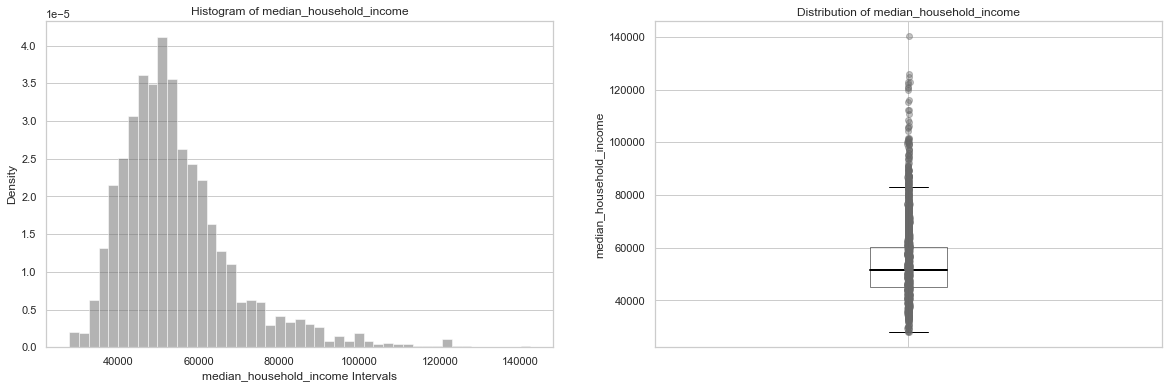

In [ ]:
histAndBox(covid.median_household_income)

The histogram shows a clear skew to the right, and the boxplot shows that we have outliers above the upper whisker. It might be beneficial to apply a log transformation so that we have more observations in the center of our data.

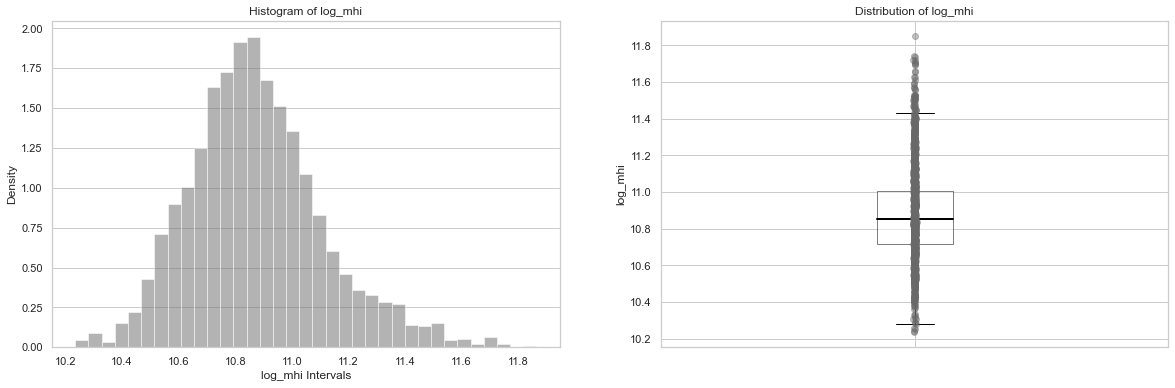

In [ ]:
covid["log_mhi"] = np.log(covid.median_household_income)
histAndBox(covid.log_mhi)

This looks more normal than before. It might be useful to apply this transformation when we build the model. I will keep this transformation in mind for the pairwise EDA.

### Education Level Distribution

The education level of each county is represented by 3 values that sum to 1. The variables represent the percentage of the population that has not graduated high school, the percentage that has graduated high school, and the percentage that has been in some college or higher.

In [ ]:
education_levels = ["less_than_high_school_diploma",
                    "high_school_diploma_only",
                    "some_college_or_higher"]
covid[education_levels].describe()

,less_than_high_school_diploma,high_school_diploma_only,some_college_or_higher
count,1961.000000,1961.000000,1961.000000
mean,12.922132,33.296022,53.780112
std,5.845095,7.365338,10.663298
min,1.700000,8.100000,24.400000
25%,8.700000,28.600000,45.900000
50%,11.800000,33.500000,53.700000
75%,16.200000,38.500000,61.300000
max,48.500000,53.100000,88.000000


All of our descriptive statistics increase as the level of education increases. It seems like higher education levels generally contain a higher percentage of the population by county. Let's make small histograms to show the distributions of these variables.

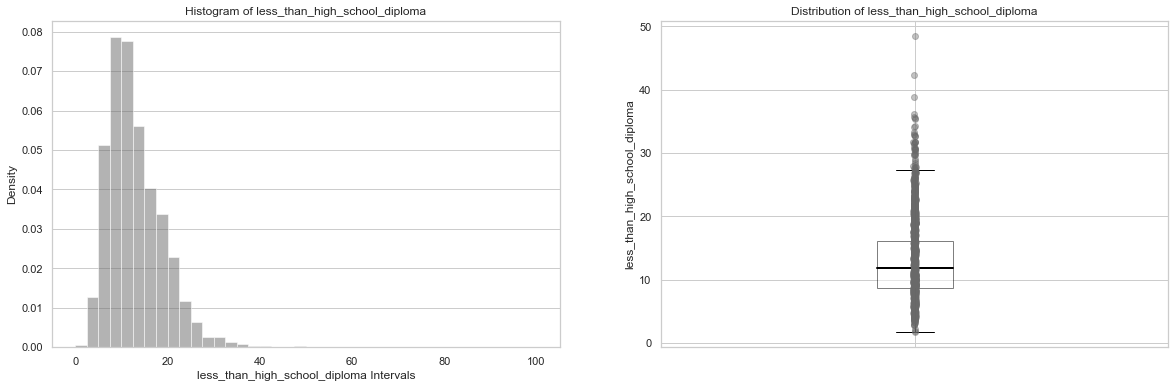

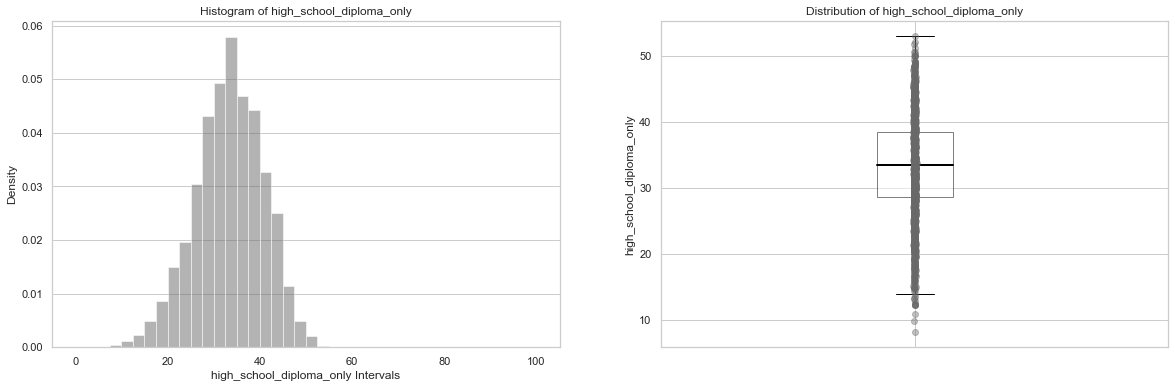

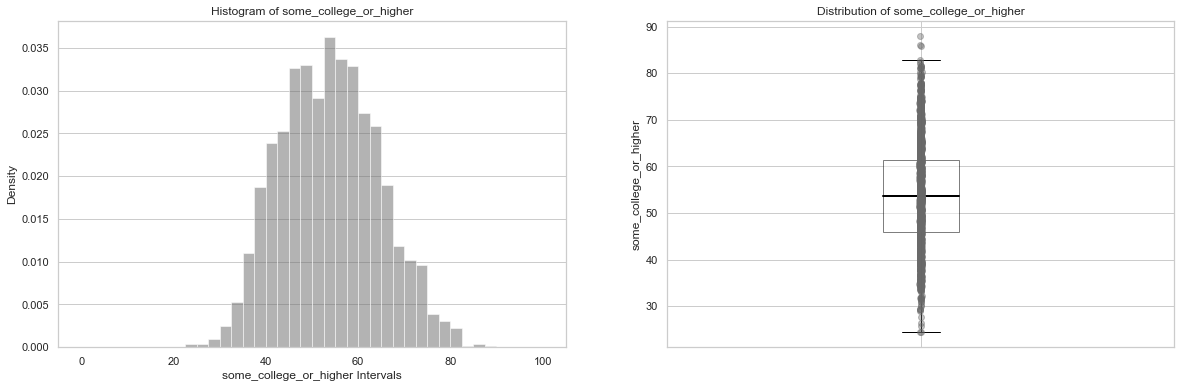

In [ ]:
binwidth = 2.5
bins = np.arange(0, 100 + binwidth, binwidth)
for level in education_levels:
  histAndBox(covid[level], in_bins=bins)

As expected, the histograms show that the higher levels of education generally hold a higher percentage of the population by county. However, it appears that there is some overlap between the groups. I want to calculate and visualize the differences between each pair of education levels.

In [ ]:
from itertools import combinations

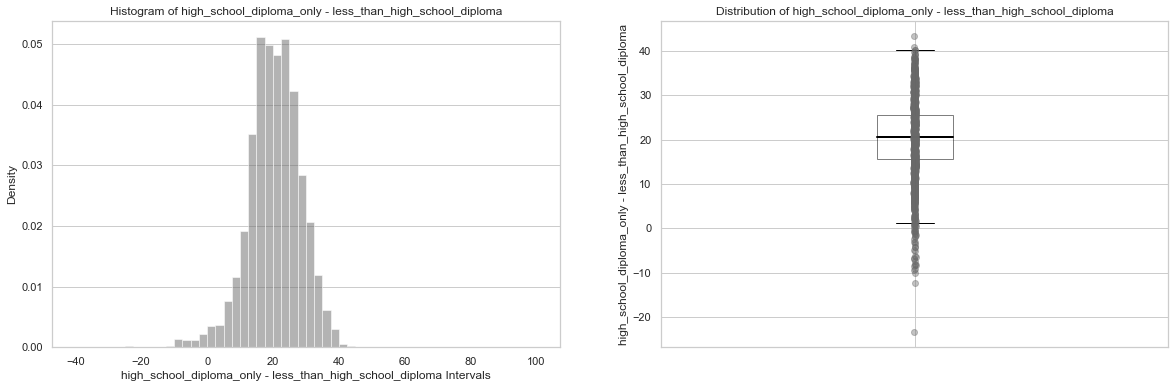

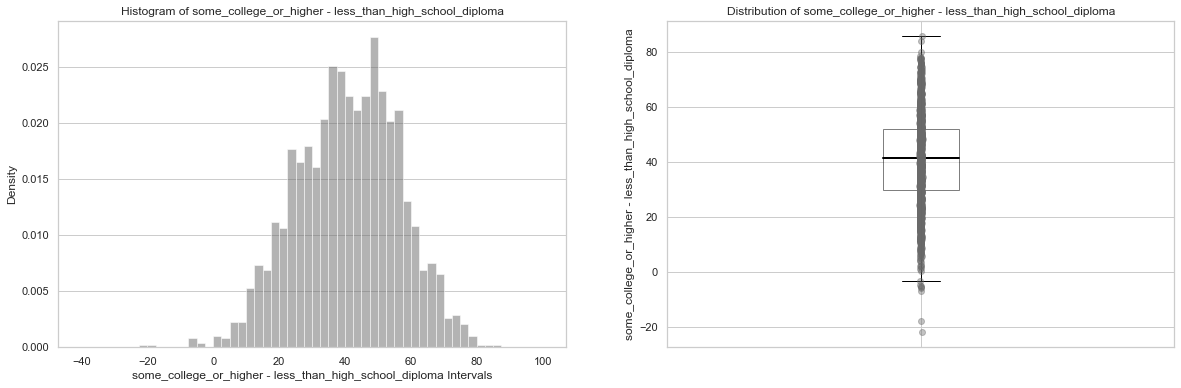

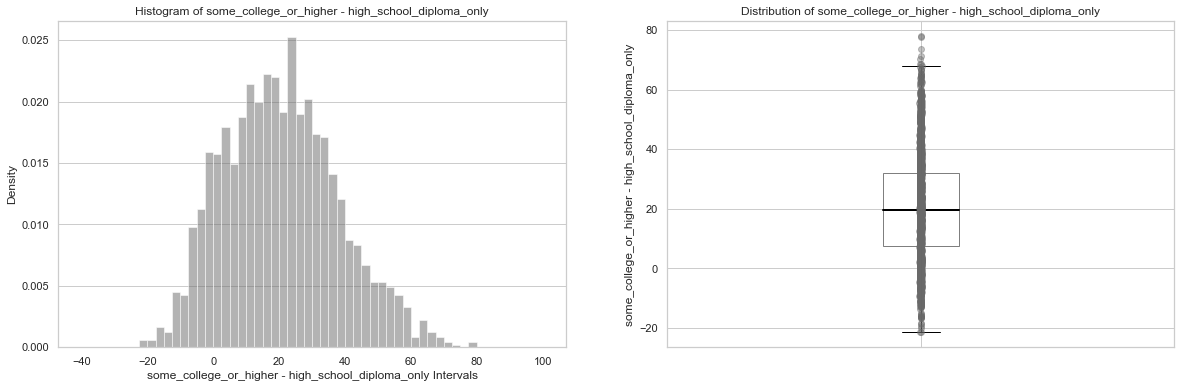

In [ ]:
education_groups = combinations(education_levels, 2)
bins = np.arange(-40, 102.5, 2.5)
education_diffs = pd.DataFrame()

for group in education_groups:
  label = group[1] + " - " + group[0]
  education_diffs[label] = covid[group[1]] - covid[group[0]]
  histAndBox(education_diffs[label], in_bins=bins)

The histograms are all mostly positive, which means most counties have a greater proportion of the population in higher education levels.

The biggest difference between the proportion of people with only high school diplomas and the proportion of people with less than a high school diploma for any county is around 40%. The proportion of people with some college or higher can be up to 80% higher than the proportion of people in either other education level.

In [ ]:
for col in education_diffs.columns:
  rope = sum(education_diffs[col] > 0) / len(education_diffs[col])
  print(col, round(rope, 3))

high_school_diploma_only - less_than_high_school_diploma 0.983
some_college_or_higher - less_than_high_school_diploma 0.996
some_college_or_higher - high_school_diploma_only 0.875


98.3\% of counties have more people with only a high school diploma than without a high school diploma. 99.6\% of counties have more people with some college or higher than without a high school diploma. 87.5\% of counties have more people with some college or higher than with only a high school diploma.

### Population Density

Population density is numeric and represents the county population over the total area of the county.

In [ ]:
covid.population_density.describe()

count     1961.000000
mean       310.432298
std       1881.553899
min          0.723268
25%         32.145449
50%         69.351457
75%        180.601321
max      71340.385458
Name: population_density, dtype: float64

The mean is very high compared to the median, and the maximum is extremely high compared to the 75th percentile. It would appear that this variable is skewed heavily to the right.

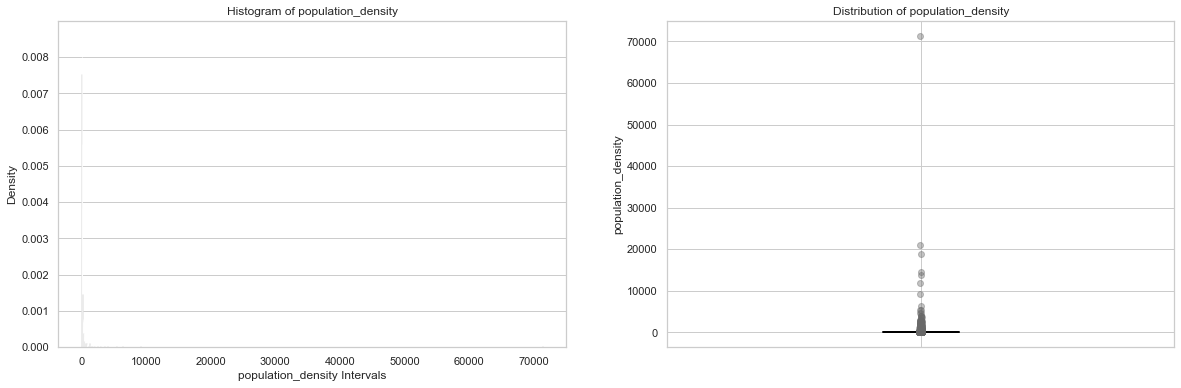

In [ ]:
histAndBox(covid.population_density)

We have very little observations for a wide range of the data. We probably need to apply some transformation to normalize this variable. Let's try a log transformation.

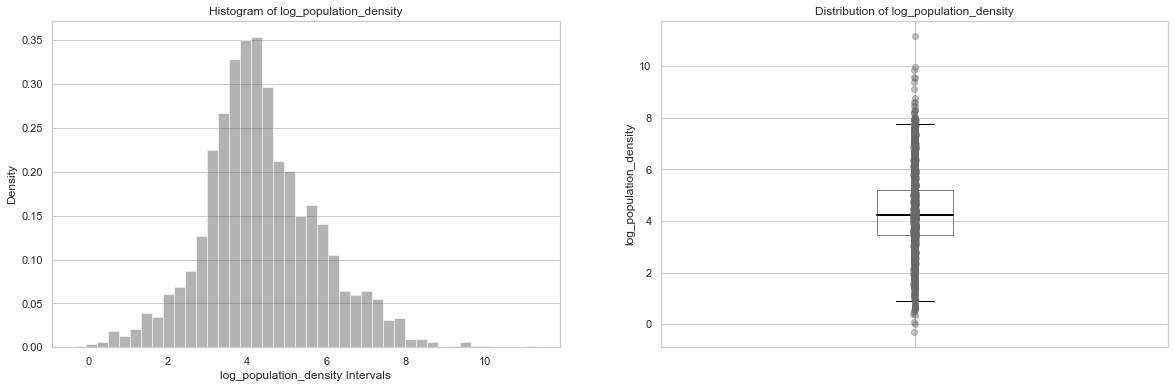

In [ ]:
covid["log_population_density"] = np.log(covid.population_density)
histAndBox(covid.log_population_density)

The log transformation makes population density look about normal. I would start with this transformation since the original data is extremely skewed.

Another option is to create an indicator variable based on population density to differentiate between high-density and low-density regions.

Since most counties have low density, I will split the data into groups by the third quartile.

In [ ]:
upper_cutoff = stats.mstats.mquantiles(covid.population_density, .75)[0]
upper_cutoff

181.15821981063104

25% of counties have higher than 181.16 population density. These will be our high-density counties.

In [ ]:
covid["high_density"] = [1 if d >= upper_cutoff else 0
                         for d in covid.population_density]

print(sum(covid.high_density), "/", len(covid.high_density), "=",
      np.mean(covid.high_density).round(3))

490 / 1961 = 0.25


By this definition, there are 490 high-density counties in the data.

## Pairwise EDA

### Median Household Income v. COVID-19 Deaths per Capita

Let's check the correlation between median household income and the target variable.

In [ ]:
correlation(covid, "median_household_income", "covid_19_deaths_per_100k")

Correlation coefficients:
r = -0.4063458980738113
rho = -0.4476041801122568


There is a weak negative linear relationship between median household income and COVID-19 deaths per capita. Spearman's rho is further from zero than Pearson's r is, which suggests that the best relationship might be nonlinear.

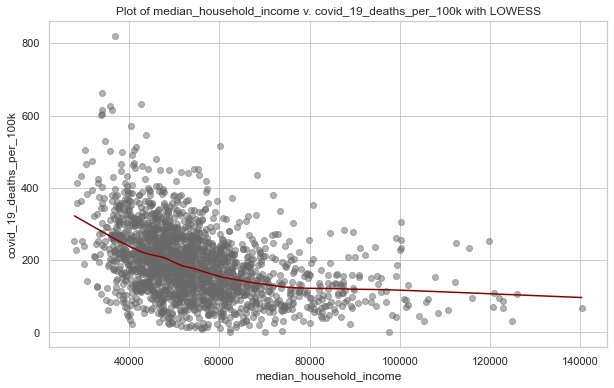

In [ ]:
lowess_scatter(covid, "median_household_income", "covid_19_deaths_per_100k")

There is a negative trend on this scatterplot, but it looks like the LOWESS line starts with more negative slope on the left than on the right. What would it look like if we use the log transformation?

In [ ]:
correlation(covid, "log_mhi", "covid_19_deaths_per_100k")

Correlation coefficients:
r = -0.4385298901154998
rho = -0.4476041801122568


Pearson's r is much closer to Spearman's rho than before. Spearman's rho is the same as the first time, since a log transformation does not change the ordering of the variable.

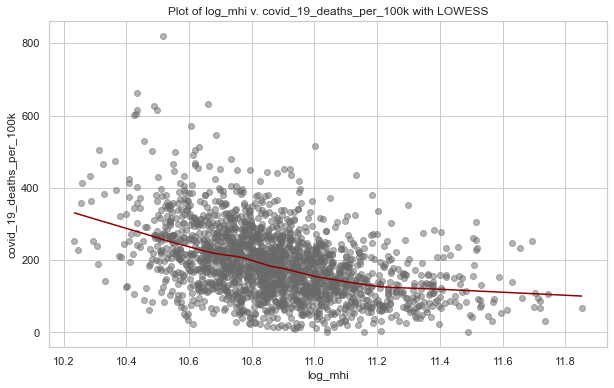

In [ ]:
lowess_scatter(covid, "log_mhi", "covid_19_deaths_per_100k")

The LOWESS line looks more linear here than on the original scatterplot. I can still see a little bit of trend on the LOWESS line compared to the linear line, but that could be explained with interactions or other variables.

I recommend using the untransformed *median_household_income* in our intial model. From there, we can determine if the log transformation on this variable adds any predictive power to the model. My reasoning is that the skew on this variable is not too extreme, and our interpretation of its coefficient from the model will be easier to state and more understandable without transformations. My expectation is that the coefficient on either term will be negative.

### Education Level Distribution v. COVID-19 Deaths per Capita

In [ ]:
for level in education_levels:
  print([level, "covid_19_deaths_per_100k"])
  correlation(covid, level, "covid_19_deaths_per_100k")

['less_than_high_school_diploma', 'covid_19_deaths_per_100k']
Correlation coefficients:
r = 0.43748286431876304
rho = 0.4538817811297064
['high_school_diploma_only', 'covid_19_deaths_per_100k']
Correlation coefficients:
r = 0.34690111709743593
rho = 0.3788394016475491
['some_college_or_higher', 'covid_19_deaths_per_100k']
Correlation coefficients:
r = -0.47941251624877357
rho = -0.5038862874438513


- The percent of the county's population with less than a high school diploma has a weak positive linear relationship with COVID-19 deaths per capita.
- The percent of the county's population with only a high school diploma has a weak positive linear relationship with COVID-19 deaths per capita.
- The percent of the county's population with some college or higher has a weak negative linear relationship with COVID-19 deaths per capita. However, there is a moderate negative nonlinear relationship between these variables.

If we want to include complete information in the model, then we should only include the two out of three of these variables. The baseline of our model will be 100% of a county's population in the level that is not included. Predictive power of the model should not change no matter which two of the three variables we choose to include in the model.

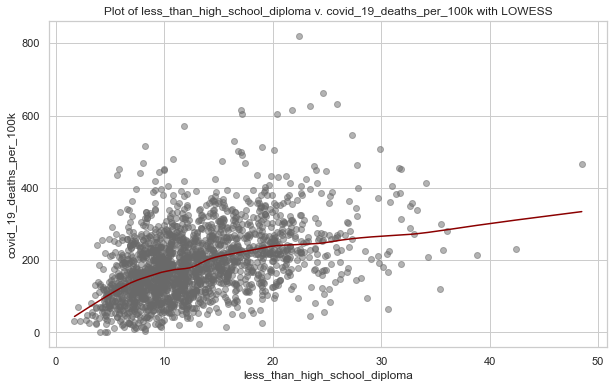

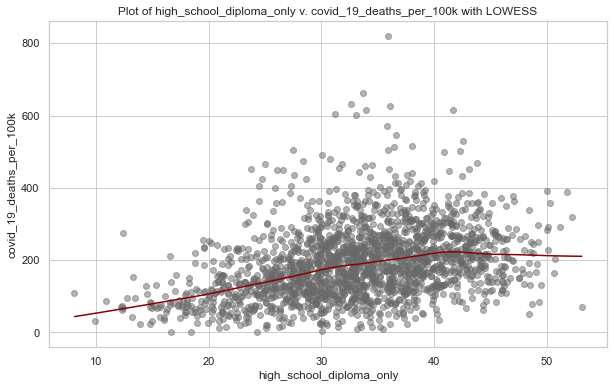

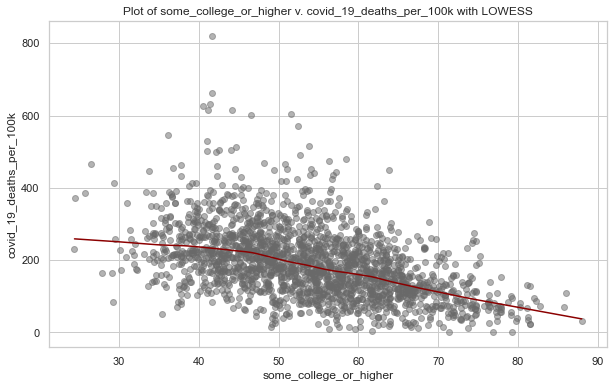

In [ ]:
for level in education_levels:
  lowess_scatter(covid, level, "covid_19_deaths_per_100k")

- The education level with the strongest correlation with the target variable is some college or higher, and the negative linear relationship is clearly visible on the last scatterplot.
- The education level with the second-strongest correlation with the target variable is less than high school diploma. The linear relationship is not as clear, but we can see a positive slope on the scatterplot.

I recommend using *some_college_or_higher* and *less_than_high_school_diploma* in the model. Since predictive power of the model is not affected by this choice, it is purely up to the interpretability of our model. First, *high_school_diploma_only* seems like a natural baseline for this variable since high school completion is usually expected. Second, setting the baseline of our model to the education level with the middle effect on our target should result in opposite signs on the two coefficients on the variables that are included, which will result in more definitive interpretations.

If one of the two terms does not pass the bounds test, we can remove it from the model but still include the other. I believe *some_college_or_higher* will be an important predictor in our model, but *less_than_high_school_diploma* might not be necessary. My expectation for the initial model is that the coefficient on *some_college_or_higher* will be negative and the coefficient on *less_than_high_school_diploma* will be positive.


### Population Density v. COVID-19 Deaths per Capita

Let's see a scatterplot without using the log transformation.

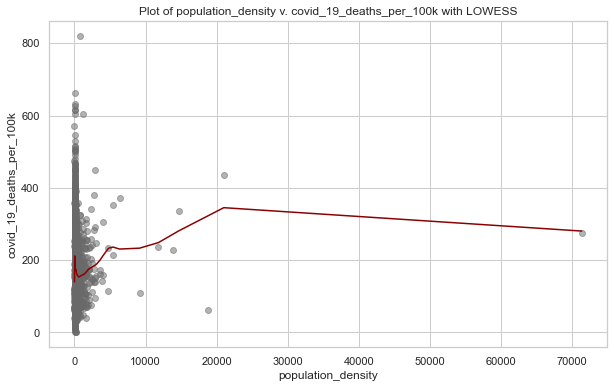

In [ ]:
lowess_scatter(covid, "population_density", "covid_19_deaths_per_100k")

All the points are jumbled on the left side of the graph, so we should probably apply a transformation to the data. Let's see what the correlation is.

In [ ]:
correlation(covid, "population_density", "covid_19_deaths_per_100k")

Correlation coefficients:
r = 0.01950303281564219
rho = -0.13327406127861594


This is a very low correlation, and we have differing signs for linear and non-linear relationships. Let's apply the log transformation.

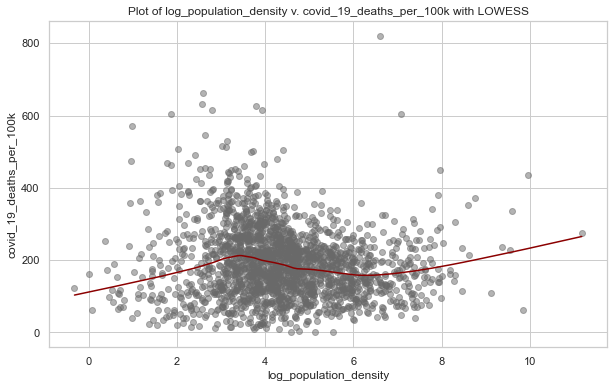

In [ ]:
lowess_scatter(covid, "log_population_density", "covid_19_deaths_per_100k")

This looks much better than before. Now there is a more even spread of observations and more data in the center; however, I don't see a definite positive or negative slope to either line.



In [ ]:
correlation(covid, "log_population_density", "covid_19_deaths_per_100k")

Correlation coefficients:
r = -0.11749861151038053
rho = -0.13327406127861594


This is a stronger correlation than before and now definitely negative, but it is still a very weak correlation. I am not sure if this variable will provide much predictive power to the model.

We can visualize COVID-19 deaths per capita for high-density and low-density counties separately to see if an indicator variable might be more useful.

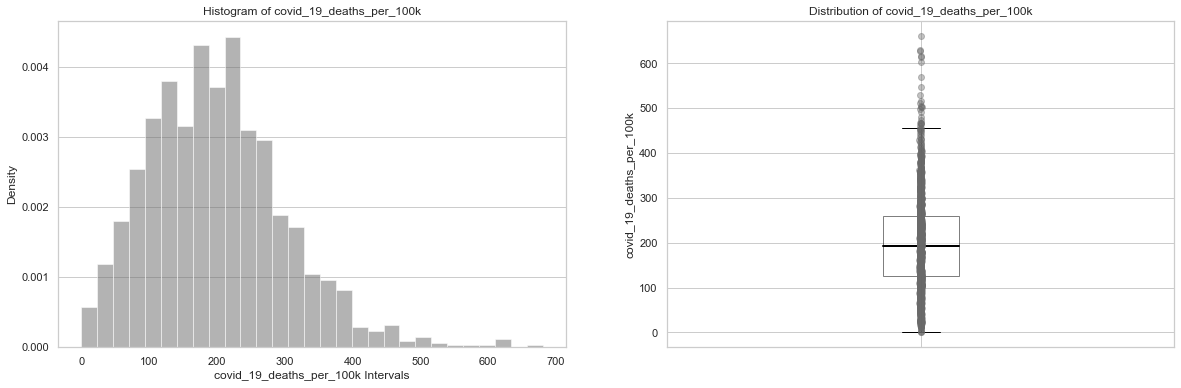

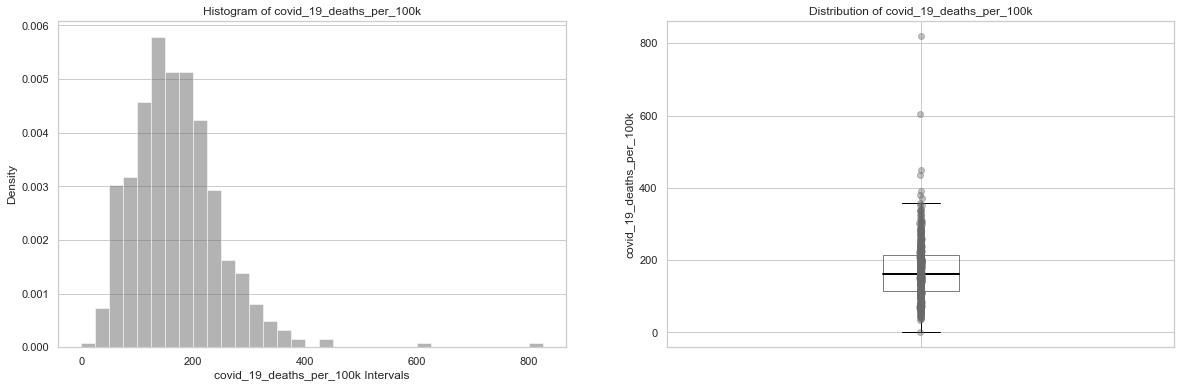

In [ ]:
histAndBox(covid[covid.high_density == 0].covid_19_deaths_per_100k)
histAndBox(covid[covid.high_density == 1].covid_19_deaths_per_100k)

On top is the distribution of COVID-19 deaths per capita for low-density counties, and on bottom is that for high-density counties. The distribution of COVID-19 deaths per capita looks skewed to the right for both types of counties; however, the maximum deaths per capita is higher for high-density counties.

In [ ]:
correlation(covid, "high_density", "covid_19_deaths_per_100k")

Correlation coefficients:
r = -0.1286790117424592
rho = -0.13143550918972374


The correlation between our indicator variable and the target variable is weaker than what we had between our log transformation and the target.

I would not recommend including *population_density* in the initial model. The relationship between this variable and COVID-19 deaths per capita is not clear, even after applying transformations. If we find that there is some unexplained trend in the residual plots after our initial model, we might want to consider including interaction effects between other variables and $log(population\_density)$ or the high-density indicator.

## Interactions between Quantitative Variables

In [ ]:
from matplotlib import cm

I'm not sure if the professor has a function like this for plotting interaction effects between 2 quantitative variables. I'm plotting a scatterplot of `x` vs. `y` and coloring them by `c`. The data is partitioned into `g` groups and I'm plotting lines with a matching color to represent the partition. I'm using the "coolwarm" color map from matplotlib since it was the most visible one I could find for a white background.

In [ ]:
def interaction_plot(data, x, y, c, g=2, size=10, width=2, cmap="coolwarm"):
    figure = plt.figure(figsize=(10, 6))
    axes = figure.add_subplot(1, 1, 1)

    p = axes.scatter(data[x], data[y], c=data[c], s=size, cmap=cmap)
    figure.colorbar(p, label=c)

    intervals = np.linspace(0, 1, g+1)
    quantiles = stats.mstats.mquantiles(data[c], intervals)
    grouped_data = []
    for i in range(len(quantiles)-1):
      group = data[quantiles[i] <= data[c]]
      group = group[group[c] <= quantiles[i+1]]
      grouped_data.append(group)

    line_colors = cm.get_cmap(cmap, g)(np.linspace(0, 1, g))
    for i in range(g):
      fit = np.polyfit(grouped_data[i][x], grouped_data[i][y], 1)
      line_x = np.linspace(data[x].min(), data[x].max(), 10)
      line = np.poly1d(fit)
      line_y = list(map(line, line_x))

      label = "[{0}, {1}]:".format(round(quantiles[i], 3),
                                   round(quantiles[i+1], 3))
      print(label, "m = {0}".format(fit[0]))
      axes.plot(line_x, line_y, linewidth=width, color=line_colors[i])

    axes.plot()

    axes.set_xlabel(x)
    axes.set_ylabel(y)

    plt.show()
    plt.close()

### Median Household Income and Education Level on COVID-19 Deaths per Capita

The more income a household has, the more money they can spend on COVID-19 preventative measures and treatments. I expect that people with a higher level of education have better research on the virus and can make each dollar worth more in terms of prevention and treatment.

[24.4, 53.7]: m = -189.25548167708033
[53.7, 88.0]: m = -91.5735850143364


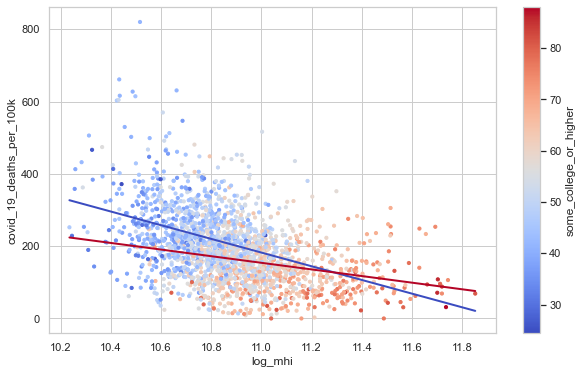

In [ ]:
interaction_plot(covid, "log_mhi", "covid_19_deaths_per_100k",
                 "some_college_or_higher")

It looks like median household income has a different effect on COVID-19 deaths per capita depending on the proportion of educated people in the county.

There is a more positive effect for counties with lots of college attendees and a more negative effect for counties with fewer college attendees, which is the opposite of what I expected.

In [ ]:
correlation(covid, "log_mhi", "some_college_or_higher")

Correlation coefficients:
r = 0.6970484062946982
rho = 0.6771208901617789


Median household income and the proportion of people with a college education have a moderate positive correlation. We can see that the points on the scatterplot gradually change color as median household income increases.

[1.7, 11.8]: m = -109.61985774802164
[11.8, 48.5]: m = -186.09201177634256


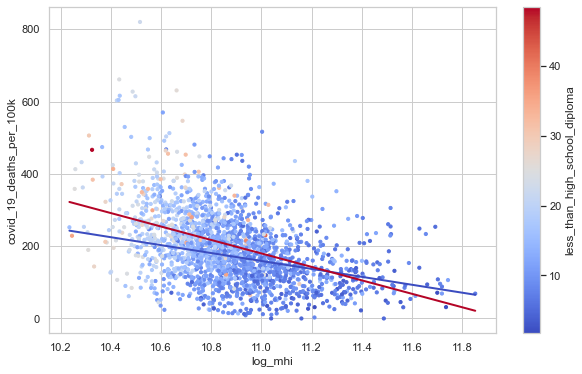

In [ ]:
interaction_plot(covid, "log_mhi", "covid_19_deaths_per_100k",
                 "less_than_high_school_diploma")

There is an opposite interaction between median household income and the proportion of the county that did not graduate high school than attended college.

In [ ]:
correlation(covid, "median_household_income", "less_than_high_school_diploma")

Correlation coefficients:
r = -0.5370252993236934
rho = -0.6469715087189807


Median household income is less correlated with the percent of people without a high school diploma than with the percent of people who have attended college.

We should start with the interaction effect between median household income and less than high school diploma before checking if the interaction with some college or higher adds any predictive power.

### Median Household Income and Population Density on COVID-19 Deaths per Capita

I chose not to include population density in the pairwise EDA, but I want to see if it might be useful in interactions. I think that median household income might have an interaction effect with population density on COVID-19 deaths per capita, since total income for the community increases with median income and with population density.

[-0.324, 4.239]: m = -240.52853163036355
[4.239, 11.175]: m = -134.3580855619706


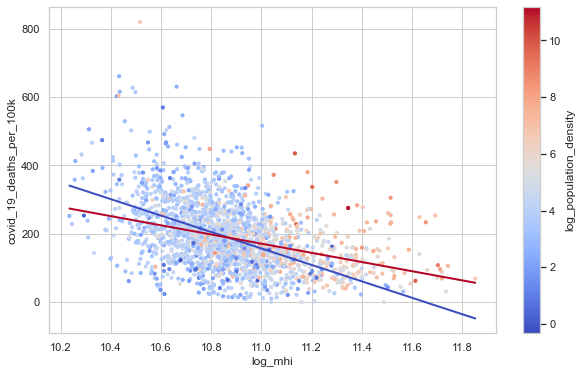

In [ ]:
interaction_plot(covid, "log_mhi", "covid_19_deaths_per_100k",
                 "log_population_density")

It looks like median household income has a more negative effect on COVID-19 deaths per capita for counties with low population density.

### Median Household Income and Percent of Diabetes on COVID-19 Deaths per Capita

[1.9, 11.5]: m = -128.15719465204475
[11.5, 31.0]: m = -200.48085587185668


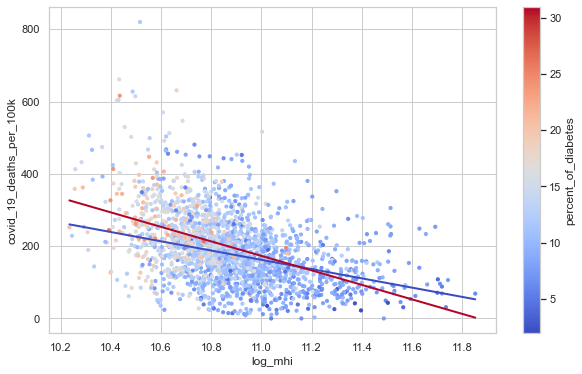

In [ ]:
interaction_plot(covid, "log_mhi", "covid_19_deaths_per_100k",
                 "percent_of_diabetes")

Median household income has a more negative effect on COVID-19 deaths per capita for counties with a higher percent of diabetes.

### Median Household Income and Percent of Vaccinated Residents on COVID-19 Deaths per Capita

[0.0, 31.7]: m = -208.40323182219905
[31.7, 78.3]: m = -131.0972879258017


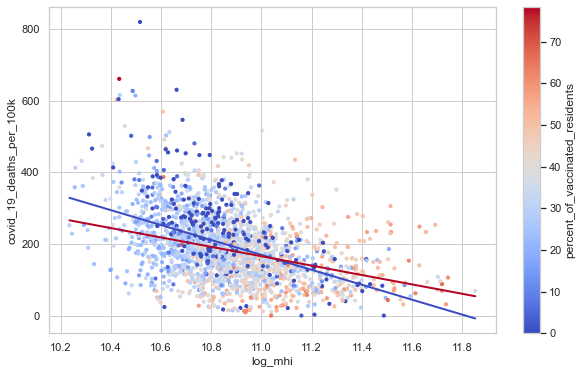

In [ ]:
interaction_plot(covid, "log_mhi", "covid_19_deaths_per_100k",
                 "percent_of_vaccinated_residents")

Median household income has a more negative effect on COVID-19 deaths per capita for counties with a lower percent of vaccinated residents.

### Education Level and Percent of Diabetes on COVID-19 Deaths per Capita

People with a higher education might have more knowledge of the fact that COVID-19 is more deadly when there are underlying health conditions.

[1.9, 11.5]: m = -4.402248592490818
[11.5, 31.0]: m = -3.3791917212410763


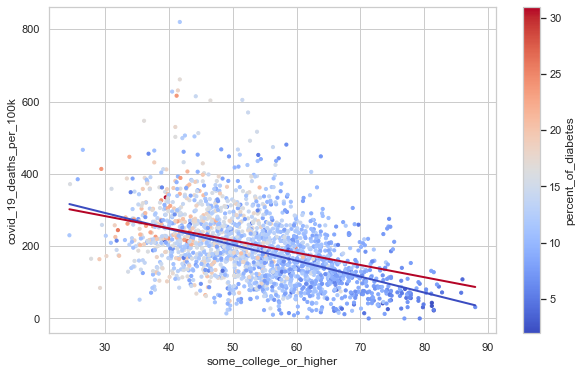

In [ ]:
interaction_plot(covid, "some_college_or_higher", "covid_19_deaths_per_100k",
                 "percent_of_diabetes")

The proportion of the county that has attended college has a more negative effect on COVID-19 deaths per capita for counties with low percent of diabetes.

[1.9, 11.5]: m = 6.7626710530831895
[11.5, 31.0]: m = 5.830050749991564


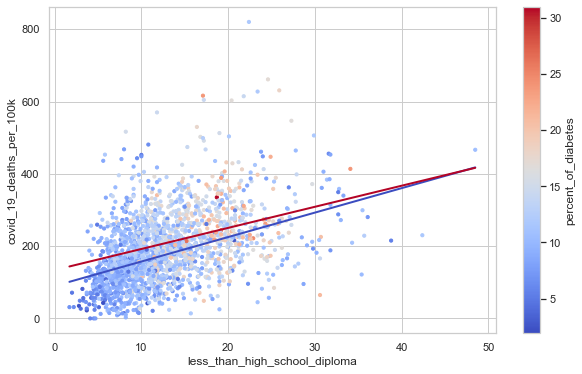

In [ ]:
interaction_plot(covid, "less_than_high_school_diploma", "covid_19_deaths_per_100k",
                 "percent_of_diabetes")

The proportion of the county that has not graduated high school has a more positive effect on COVID-19 deaths per capita for counties with low percent of diabetes.

### Population Density and Ventilator Capacity Ratio on COVID-19 Deaths per Capita

Higher population density means that there are less medical supplies per person.

[-0.324, 4.239]: m = 52068.71971395643
[4.239, 11.175]: m = 26692.772159040516


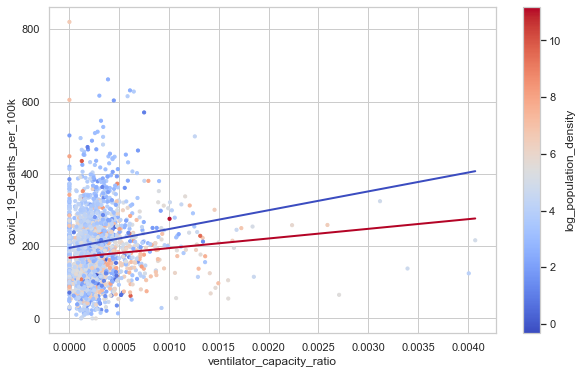

In [ ]:
interaction_plot(covid, "ventilator_capacity_ratio", "covid_19_deaths_per_100k",
                 "log_population_density")

Population density has a more positive effect on COVID-19 deaths for counties with lower population density.

## Interactions with a Binary Feature

In [ ]:
from matplotlib.patches import Patch

In [ ]:
scheme = ["#47a", "#e67", "#283", "#cb4", "#6ce", "#a37"]
colorAlpha = .8

def color_scatter(data, x, y, c, show_lines=True):
  colors = data[c].apply(lambda x: scheme[x])

  figure = plt.figure(figsize=(10, 6))

  axes = figure.add_subplot(1, 1, 1)
  axes.scatter(data[x], data[y], marker="o", color=colors, alpha=colorAlpha)

  axes.set_ylabel(y)
  axes.set_xlabel(x)
  axes.set_title("Scatter Plot of " + y + " vs. " + x + " (" + c + ")")

  unique = data[c].unique()
  patches = []

  for i in range(len(unique)):
    patches.append(Patch(color=scheme[i], label=c + " = " + str(unique[i])))

    if show_lines:
        grouped_data = data[data[c] == unique[i]]
        fit = np.polyfit(grouped_data[x], grouped_data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line_y = list(map(np.poly1d(fit), line_x))
        axes.plot(line_x, line_y, linewidth=2, color=scheme[i])

  plt.legend(handles=patches)

  plt.show()
  plt.close()

### Population Density

I expect social distancing GPA for travel and COVID-19 deaths per capita to have a more positive relationship for high-density counties than for low-density counties. It makes sense that COVID-19 spreads more easily in a high-density county, and the more people in a high-density county are travelling, the more COVID-19 exists in that county to spread.

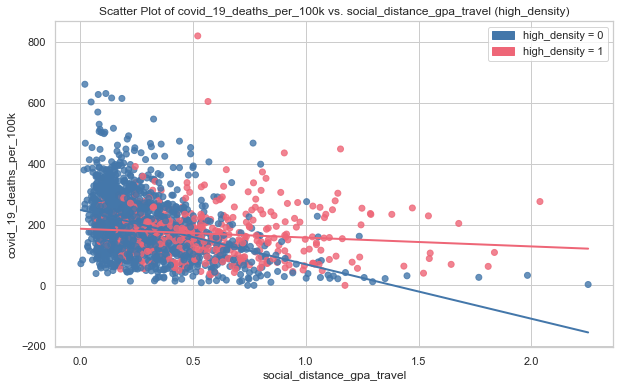

In [ ]:
color_scatter(covid, "social_distance_gpa_travel", "covid_19_deaths_per_100k",
              "high_density")

As expected, the slope of the relationship between social distance GPA travel and COVID-19 deaths per capita is more positive for high-density counties than for low-density counties; however, both relationships are negative. This is to say that a higher social distance GPA travel generally results in lower COVID-19 deaths per capita, and this effect is stronger for low-density counties than for high-density counties.

We should explore the interaction effect between population density and median household income. I think income will have a more negative effect on COVID-19 deaths per capita in low-density counties than in high-density counties. In a low-density county, more wealth might make it easier to distance yourself from the rest of the community than in a high-density county.

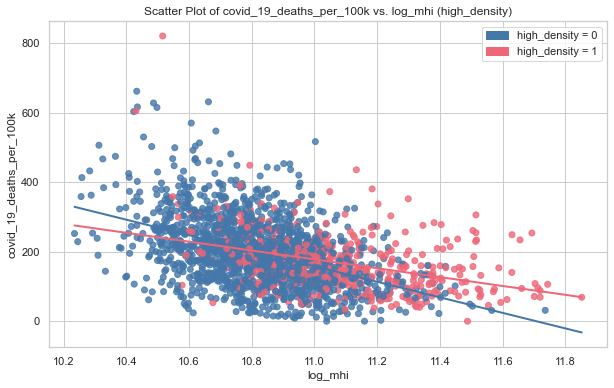

In [ ]:
color_scatter(covid, "log_mhi", "covid_19_deaths_per_100k",
              "high_density")

Median household income has a negative effect on COVID-19 deaths per capita, and this effect is more negative for low-density counties than it is for high-density counties.

I want to see the interaction between population density and percent of smokers on COVID-19 deaths per capita. In a high-density county with a high proportion of smokers, I expect that more people are affected by second-hand smoke than in other counties. It is possible that second-hand smoke could cause an underlying health condition which puts people more at risk for COVID-19 death.

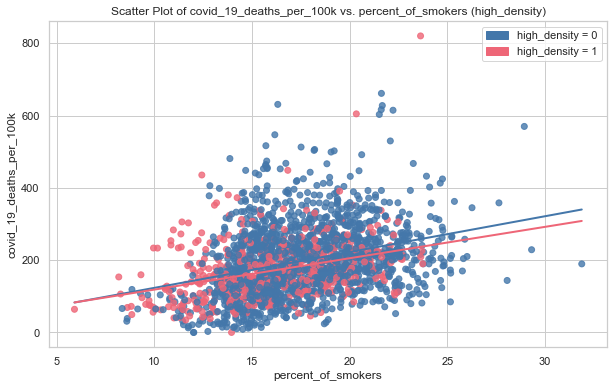

In [ ]:
color_scatter(covid, "percent_of_smokers", "covid_19_deaths_per_100k",
              "high_density")

The slope of the lines for each group are not very different; however, it looks like there is more variance in COVID-19 deaths per capita as the percent of smokers increases for low-density counties. High-density counties generally seem to have a lower percent of smokers and less variance in COVID-19 deaths per capita.

I want to see the interaction effect between population density and ventilator capacity ratio. The equation for this interaction effect is:

$population\_density*ventilator\_capacity\_ratio=(\frac{population}{area})(\frac{ventilators}{population}) = \frac{ventilators}{area}$.

We are measuring the amount of ventilators proportional to the size of the county. This is a measure of the accessibility of ventilators in the county, where a lower number means that people generally need to travel a greater distance to access a ventilator.

I expect that the ventilator capacity ratio will have a more negative effect on COVID-19 deaths per capita for high-density counties, since the ratio is dependent on population and a higher population that means there are more ventilators.

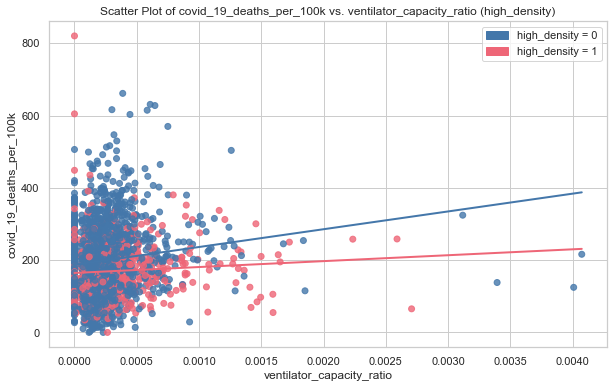

In [ ]:
color_scatter(covid, "ventilator_capacity_ratio", "covid_19_deaths_per_100k",
              "high_density")

Ventilator capacity ratio has a positive effect on COVID-19 deaths per capita, and the effect is more positive for low-density counties than it is for high-density counties.

I would try including all four of these interaction effects and checking if they increase predictive power of the model compared to a base model with no interaction terms.

## Initial Model

### Linear Regression Functions

In [ ]:
import sklearn.linear_model as linear
import patsy

chartColor = "DimGray"
chartAlpha=0.5

def restyle_boxplot(patch):
    ## change color and linewidth of the whiskers
    for whisker in patch['whiskers']:
        whisker.set(color='#000000', linewidth=1)
    ## change color and linewidth of the caps
    for cap in patch['caps']:
        cap.set(color='#000000', linewidth=1)
    ## change color and linewidth of the medians
    for median in patch['medians']:
        median.set(color='#000000', linewidth=2)
    ## change the style of fliers and their fill
    for flier in patch['fliers']:
        flier.set(marker='o', color='#000000', alpha=0.0)
    for box in patch["boxes"]:
        box.set( facecolor='#FFFFFF', alpha=0.5)

def freeman_diaconis(data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    bins = np.arange(data.min(), data.max() + h, h)
    return bins

def histChart(axes,data,isDensity=True,in_bins=None,in_xlim=None):
    if in_bins is None:
        in_bins = freeman_diaconis(data)
    axes.hist(data, bins=in_bins,color=chartColor, density=isDensity, alpha=chartAlpha)
    axes.set_ylabel( "Density" if isDensity else "Frequency" )
    axes.set_xlabel(f"{data.name} Intervals")
    axes.set_title(f"Histogram of {data.name}")
    axes.xaxis.grid(False)
    axes.set_xlim(in_xlim)

def boxPlot(axes,data):
    patch = axes.boxplot(data, labels=[''], showfliers=True, patch_artist=True, zorder=1)
    restyle_boxplot(patch)
    axes.set_title(f"Distribution of {data.name}")
    axes.set_ylabel(f"{data.name}")
    x = np.random.normal(1, 0.001, size=len(data))
    axes.plot(x, data, 'o', alpha=0.4, color=chartColor, zorder=2)

def histAndBox(data,in_bins=None):
    fig = plt.figure(figsize=(20,6))
    axes = fig.add_subplot(1,2,1)
    histChart(axes,data,in_bins=in_bins)
    axes = fig.add_subplot(1,2,2)
    boxPlot(axes,data)
    plt.show()
    plt.close()

def cdfCompare(data,distData,distType):
    figure = plt.figure(figsize=(20, 8))
    ticket_mn = np.min(data)
    ticket_mx = np.max(data)

    axes = figure.add_subplot(1, 2, 1)
    values, base = np.histogram(data, bins=20, density=True)
    cumulative = np.cumsum(values)
    axes.plot(base[:-1], cumulative, color="steelblue")
    axes.set_xlim((ticket_mn, ticket_mx))

    values2, base = np.histogram(distData, bins=base, density=True)

    cumulative2 = np.cumsum(values2)
    axes.plot( base[:-1], cumulative2, color="firebrick")
    axes.set_xlim((ticket_mn, ticket_mx))
    axes.set_xlabel(f"Empirical v. Theoretical: {distType}")

    axes = figure.add_subplot(1, 2, 2)

    differences = cumulative2 - cumulative
    axes.plot(base[:-1], differences, color='firebrick')
    axes.set_xlim((ticket_mn, ticket_mx))
    axes.hlines(0, 0, 14000, linestyles="dotted")
    axes.set_xlabel(f"Empirical v. Theoretical: {distType} Distribution, Difference")

    plt.show()
    plt.close()

def correlation(data, x, y):
    print("Correlation coefficients:")
    print( "r =", stats.pearsonr(data[x], data[y])[0])
    print( "rho =", stats.spearmanr(data[x], data[y])[0])

def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):
    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 6))
    axes = figure.add_subplot(1, 1, 1)
    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)
    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")

    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)
    plt.show()
    plt.close()

def multiboxplot(data, numeric, categorical, skip_data_points=True):
    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    grouped = data.groupby(categorical)
    labels = pd.unique(data[categorical].values)
    labels.sort()
    grouped_data = [grouped[numeric].get_group( k) for k in labels]
    patch = axes.boxplot( grouped_data, labels=labels, patch_artist=True, zorder=1)
    restyle_boxplot( patch)

    if not skip_data_points:
        for i, k in enumerate(labels):
            subdata = grouped[numeric].get_group( k)
            x = np.random.normal(i + 1, 0.01, size=len(subdata))
            axes.plot(x, subdata, 'o', alpha=0.4, color="DimGray", zorder=2)

    axes.set_xlabel(categorical)
    axes.set_ylabel(numeric)
    axes.set_title("Distribution of {0} by {1}".format(numeric, categorical))
    plt.xticks(rotation = 45)
    plt.show()
    plt.close()

def fmt(n, sd=2):
    return (r"{0:." + str(sd) + "f}").format(n)

def boldify(xs, format):
    if format == "html":
        return ["<strong>" + x + "</strong>" if x != "" else "" for x in xs]
    if format == "markdown":
        return ["**" + x + "**" if x != "" else "" for x in xs]
    # latex
    return ["\\textbf{" + x + "}" if x != "" else "" for x in xs]

def bootstrap_linear_regression( formula, data=None, samples=100, style="linear", params={}):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    bootstrap_results = {}
    bootstrap_results[ "formula"] = formula

    variables = [x.strip() for x in formula.split("~")[1].split( "+")]
    variables = ["intercept"] + variables
    bootstrap_results[ "variables"] = variables

    coeffs = []
    sigmas = []
    rs = []

    n = len(data)
    bootstrap_results[ "n"] = n

    for i in range( samples):
        sampling = data.sample(len(data), replace=True)
        results = linear_regression( formula, data=sampling, style=style, params=params)
        coeffs.append( results[ "coefficients"])
        sigmas.append( results[ "sigma"])
        rs.append( results[ "r_squared"])

    coeffs = pd.DataFrame( coeffs, columns=variables)
    sigmas = pd.Series( sigmas, name="sigma")
    rs = pd.Series( rs, name="r_squared")

    bootstrap_results[ "resampled_coefficients"] = coeffs
    bootstrap_results[ "resampled_sigma"] = sigmas
    bootstrap_results[ "resampled_r^2"] = rs

    result = linear_regression( formula, data=data)

    bootstrap_results[ "residuals"] = result[ "residuals"]
    bootstrap_results[ "coefficients"] = result[ "coefficients"]
    bootstrap_results[ "sigma"] = result[ "sigma"]
    bootstrap_results[ "r_squared"] = result[ "r_squared"]
    bootstrap_results["model"] = result["model"]
    bootstrap_results["y"] = result["y"]
    bootstrap_results["y_hat"] = result["y_hat"]
    return bootstrap_results

def results_table(fit, sd=2,bootstrap=False, is_logistic=False, format="html"):
    result = {}
    result["model"] = [fit["formula"]]

    variables = [v.strip() for v in [""] + fit["formula"].split("~")[1].split( "+")]
    if format == 'latex':
        variables = [v.replace("_", "\\_") for v in variables]
    coefficients = []

    if bootstrap:
        bounds = fit[ "resampled_coefficients"].quantile([0.025, 0.975])
        bounds = bounds.transpose()
        bounds = bounds.values.tolist()
        for i, b in enumerate(zip(variables, fit["coefficients"], bounds)):
            coefficient = [b[0], f"$\\beta_{{{i}}}$", fmt(b[1], sd), fmt(b[2][0], sd), fmt(b[2][1], sd)]
            if is_logistic:
                if i == 0:
                    coefficient.append(fmt(logistic(b[1]), sd))
                else:
                    coefficient.append(fmt(b[1]/4, sd))
            coefficients.append(coefficient)
    else:
        for i, b in enumerate(zip(variables, fit["coefficients"])):
            coefficients.append([b[0], f"$\\beta_{{{i}}}$", fmt(b[1], sd)])
    result["coefficients"] = coefficients

    error = r"$\sigma$"
    r_label = r"$R^2$"
    if is_logistic:
        error = "Error (%)"
        r_label = r"Efron's $R^2$"
    if bootstrap:
        sigma_bounds = stats.mstats.mquantiles( fit[ "resampled_sigma"], [0.025, 0.975])
        r_bounds = stats.mstats.mquantiles( fit[ "resampled_r^2"], [0.025, 0.975])
        metrics = [
            [error, fmt(fit["sigma"], sd), fmt(sigma_bounds[0], sd), fmt(sigma_bounds[1], sd)],
            [r_label, fmt(fit["r_squared"], sd), fmt(r_bounds[0], sd), fmt(r_bounds[1], sd)]]
    else:
        metrics = [
            [error, fmt(fit["sigma"], sd)],
            [r_label, fmt(fit["r_squared"], sd)]]

    result["metrics"] = metrics

    title = f"Model: {result['model'][0]}"
    rows = []
    if bootstrap:
        rows.append(boldify(["", "", "", "95% BCI"], format))
    if is_logistic:
        if bootstrap:
            header = boldify(["Coefficients", "", "Mean", "Lo", "Hi", "P(y=1)"], format)
        else:
            header = boldify(["Coefficients", "", "Value"], format)
    else:
        if bootstrap:
            header = boldify(["Coefficients", "", "Mean", "Lo", "Hi"], format)
        else:
            header = boldify(["Coefficients", "", "Value"], format)
    rows.append(header)

    for row in result["coefficients"]:
        rows.append(row)

    rows.append([])

    if bootstrap:
        rows.append(boldify(["Metrics", "Mean", "Lo", "Hi"], format))
    else:
        rows.append(boldify(["Metrics", "Value"], format))
    for row in result["metrics"]:
        rows.append(row)

    return title, rows

class ResultsWrapper(object):
    def __init__(self, fit, sd=2, bootstrap=False, is_logistic=False):
        self.fit = fit
        self.sd = sd
        self.bootstrap = bootstrap
        self.is_logistic = is_logistic

    def _repr_markdown_(self):
        title, table = results_table(self.fit, self.sd, self.bootstrap, self.is_logistic, format="markdown")
        table = tabulate(table, tablefmt="github")
        markdown = title + "\n" + table
        return markdown

    def _repr_html_(self):
        title, table = results_table(self.fit, self.sd, self.bootstrap, self.is_logistic, format="html")
        table = tabulate(table, tablefmt="html")
        table = table.replace("&lt;strong&gt;", "<strong>").replace("&lt;/strong&gt;", "</strong")
        return f"<p><strong>{title}</strong><br/>{table}</p>"

    def _repr_latex_(self):
        title, table = results_table(self.fit, self.sd, self.bootstrap, self.is_logistic, format="latex")

        title = title.replace("~", "$\\sim$").replace("_", "\\_")

        table = tabulate(table, tablefmt="latex_booktabs")
        table = table.replace("textbackslash{}", "").replace("\^{}", "^").replace("\_", "_")
        table = table.replace("\\$", "$").replace("\\{", "{").replace("\\}", "}")
        latex = "\\textbf{" + title + "}\n\n" + table
        return latex

def describe_bootstrap_lr(fit, sd=2):
    return ResultsWrapper(fit, sd, True, False)

ALGORITHMS = {
    "linear": linear.LinearRegression,
    "ridge": linear.Ridge,
    "lasso": linear.Lasso
}

def summarize(formula, X, y, model, style='linear'):
    result = {}
    result["formula"] = formula
    result["n"] = len(y)
    result["model"] = model
    # I think this is a bug in Scikit Learn
    # because lasso should work with multiple targets.
    if style == "lasso":
        result["coefficients"] = model.coef_
    else:
        result["coefficients"] =  model.coef_[0]
    result["r_squared"] = model.score( X, y)
    y_hat = model.predict(X)
    result["residuals"] = y - y_hat
    result["y_hat"] = y_hat
    result["y"]  = y
    sum_squared_error = sum([e**2 for e in result[ "residuals"]])[0]

    n = len(result["residuals"])
    k = len(result["coefficients"])

    try:
      result["sigma"] = np.sqrt( sum_squared_error / (n - k))
    except RuntimeError as err:
      print(f"Unexpected {err}, {type(err)}")
      print(sum_squared_error,n,k)

    return result

def linear_regression(formula, data=None, style="linear", params={}):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    params["fit_intercept"] = False

    y, X = patsy.dmatrices(formula, data, return_type="matrix")
    algorithm = ALGORITHMS[style]
    algo = algorithm(**params)
    model = algo.fit( X, y)

    result = summarize(formula, X, y, model, style)

    return result

def strength(pr):
    if 0 <= pr <= 0.33:
        return "weak"
    if 0.33 < pr <= 0.66:
        return "mixed"
    return "strong"

# {"var1": "+", "var2": "-"}
def evaluate_coefficient_predictions(predictions, result):
    coefficients = result["resampled_coefficients"].columns
    for coefficient in coefficients:
        if coefficient == 'intercept':
            continue
        if predictions[coefficient] == '+':
            pr = np.mean(result["resampled_coefficients"][coefficient] > 0)
            print("{0} P(>0)={1:.3f} ({2})".format(coefficient, pr, strength(pr)))
        else:
            pr = np.mean(result["resampled_coefficients"][coefficient] < 0)
            print("{0} P(<0)={1:.3f} ({2})".format(coefficient, pr, strength(pr)))

def adjusted_r_squared(result):
    adjustment = (result["n"] - 1)/(result["n"] - len(result["coefficients"]) - 1 - 1)
    return 1 - (1 - result["r_squared"]) * adjustment

def residualsChart(axes,feature,residuals,in_ylim=None,add_trend=False,sort_x=True):
    keyed_values = sorted(zip(feature, residuals), key=lambda x: x[ 0])
    residuals = [x[ 1][ 0] for x in keyed_values]
    if sort_x:
        xs = list(range(0, len(residuals)))
    else:
        xs = [x[ 0] for x in keyed_values]
    axes.plot(xs, residuals, '.', color="dimgray", alpha=0.75)
    axes.axhline(y=0.0, xmin=0, xmax=len(residuals), c="black", alpha=0.5)
    if add_trend:
        fit = np.polyfit(xs, residuals, 1)
        line_x = np.linspace(min(xs), max(xs), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
        axes.plot(line_x, line_y, color="DarkRed")
    axes.set_title( f"{feature.name} v. residuals")
    axes.set_ylim(in_ylim)
    axes.set_ylabel("Residuals")
    axes.set_xlabel(f"Fitted Data")

def sigma_metric(result):
    return result['sigma'];

def sse(results):
    errors = results['residuals']
    n = len( errors)
    squared_error = np.sum( [e**2 for e in errors])
    return np.sqrt((1.0/n) * squared_error)

def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []; metrics.append([]);metrics.append([]);metrics.append([]) # ADDED THIS CODE
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics[0].append(metric)               # ADDED THIS CODE
            metrics[1].append(results["r_squared"]) # ADDED THIS CODE
            metrics[2].append(results["sigma"])     # ADDED THIS CODE
    return metrics

def resample(data):
    n = len(data)
    return [data[ i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

from collections import defaultdict
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

#1. split your data into a training/test set. You use one set of folds from 10 fold cross,!validation.
#2. create subsets of your training data of ever increasing size, n% to 100%.
#3. train the model using the training subset.
#4. calculate your metric on the training subset and keep it
#5. calculate your metric on the test set and save it.
#6. plot the saved metrics as the "train curve" and the "test curve".
def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3,increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results

def results_to_curves( curve, results):
    all_statistics = results[curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

def plot_learning_curves( results, metric, desired=None, zoom=False, credible=True,
                         in_xlim=None,in_ylim=None):
    figure = plt.figure(figsize=(10,6))
    axes = figure.add_subplot(1, 1, 1)
    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    ## Added By EAF on 8/8/22 to deal wiht NaN values #####
    train_lower = np.nan_to_num(train_lower)
    train_mean = np.nan_to_num(train_mean)
    train_upper = np.nan_to_num(train_upper)
    #######################################################
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)
    axes.plot( xs, train_mean, color="steelblue", label="train")
    axes.plot( xs, test_mean, color="firebrick", label="test")
    if credible:
        axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25)
        axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25)
    if desired:
        if type(desired) is tuple:
            axes.axhline((desired[0] + desired[1])/2.0, color="gold", label="desired")
            axes.fill_between( xs, desired[1], desired[0], color="gold", alpha=0.25)
        else:
            axes.axhline( desired, color="gold", label="desired")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")
    if zoom:
      ## Added EAF 8/8/22 #############
      axes.set_xlim(in_xlim)
      if in_ylim != None:
        y_lower = in_ylim[0]
        y_upper = in_ylim[1]
      else:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
      #################################
      axes.set_ylim((y_lower, y_upper))
    plt.show()
    plt.close()

In [ ]:
def validation_curves(algorithm, formulas, data, values, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        np.random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i, p in enumerate(zip(formulas, values)):
                f, v = p
                # it's ok to resuse the folds for each v of values
                # we calculate the model
                result = algorithm(f, train_data, v)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices(f, train_data, return_type="matrix")
                result = summarize(f, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)

                # we calculate the results for the test data.
                y, X = patsy.dmatrices(f, test_data, return_type="matrix")
                result = summarize(f, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results
    #

def plot_validation_curves( results, metric, parameter, values, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( values, train_mean, color="steelblue")
    axes.fill_between( values, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( values, test_mean, color="firebrick")
    axes.fill_between( values, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( parameter)
    axes.set_ylabel( metric)
    axes.set_title("Validation Curves")

    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))

    plt.show()
    plt.close()

### Construct Age Variables

In [ ]:
Ages = ['age_0_4', 'age_5_9', 'age_10_14',
       'age_15_19', 'age_20_24', 'age_25_29', 'age_30_34', 'age_35_39',
       'age_40_44', 'age_45_49', 'age_50_54', 'age_55_59', 'age_60_64',
       'age_65_69', 'age_70_74', 'age_75_79', 'age_80_84', 'age_85_or_higher']
age_summary = []
for age in Ages:
    age_summary.append([age, stats.pearsonr(covid[age], covid['covid_19_deaths_per_100k'])[0],
                        stats.spearmanr( covid[age], covid['covid_19_deaths_per_100k'])[0]])

In [ ]:
covid['kid'] = covid['age_0_4'] +  covid['age_5_9'] + covid['age_10_14']
covid['adult'] = covid['age_15_19'] + covid['age_20_24'] + covid['age_25_29'] + \
    covid['age_30_34'] + covid['age_35_39'] + covid['age_40_44'] + covid['age_45_49'] + \
    covid['age_50_54'] + covid['age_55_59'] + covid['age_60_64']
covid['old'] = covid['age_65_69'] + covid['age_70_74'] + covid['age_75_79'] + \
    covid['age_80_84'] + covid['age_85_or_higher']

In [ ]:
covid['Age'] = (2*covid['age_0_4'] +  7*covid['age_5_9'] + 12*covid['age_10_14'] + 17*covid['age_15_19'] + 22*covid['age_20_24']
                + 27*covid['age_25_29'] + 32*covid['age_30_34'] + 37*covid['age_35_39'] + 42*covid['age_40_44'] + 47*covid['age_45_49']
                + 52*covid['age_50_54'] + 57*covid['age_55_59'] + 62*covid['age_60_64']+ 67*covid['age_65_69'] + 72*covid['age_70_74']
                + 74*covid['age_75_79'] + 82*covid['age_80_84'] + 87*covid['age_85_or_higher'])/100

### Exploring Interactions

I'm going to start with the log transformation on median household income to see if that increases predictive power.

In [ ]:
formula = 'covid_19_deaths_per_100k ~ percent_of_diabetes + '\
          'percent_of_smokers + log_mhi + '\
          'some_college_or_higher + less_than_high_school_diploma + adult + '\
          'old + hospital_beds_ratio + ventilator_capacity_ratio + '\
          'social_distance_gpa_travel + social_distance_gpa_visitation + '\
          'percent_of_vaccinated_residents'
result = bootstrap_linear_regression(formula, data=covid)
adjusted_r_squared(result)

0.32244055673590966

Adjusted R-squared is higher than before the log transformation on median household income.

I'm going to add each interaction effect to the base model one at a time to see which have the highest increase in adjusted R-squared.

In [ ]:
from itertools import combinations

WARNING: The next chunk took me about 7 minutes to run.

In [ ]:
# single_terms = ["percent_of_diabetes", "percent_of_smokers", "log_mhi",
#                 "some_college_or_higher", "less_than_high_school_diploma",
#                 "adult", "old", "hospital_beds_ratio",
#                 "ventilator_capacity_ratio", "log_population_density",
#                 "social_distance_gpa_travel", "social_distance_gpa_visitation",
#                 "percent_of_vaccinated_residents"]

# scores = pd.DataFrame()

# for pair in combinations(single_terms, 2):
#   f = formula + " + " + pair[0] + ":" + pair[1]
#   result = bootstrap_linear_regression(f, data=covid)
#   adj_r_sq = adjusted_r_squared(result)
#   scores = scores.append([[*pair, adj_r_sq]])

# scores.columns = ["var_1", "var_2", "adj_r_sq"]
# print(scores.sort_values(by="adj_r_sq", ascending=False).head(10))

In [ ]:
formula_1 = formula + " + log_population_density:social_distance_gpa_travel \
                        + log_population_density:log_mhi \
                        + log_population_density:percent_of_smokers \
                        + log_population_density:ventilator_capacity_ratio"
result_1 = bootstrap_linear_regression(formula_1, data=covid)
adjusted_r_squared(result_1)

0.35590900636099

In [ ]:
describe_bootstrap_lr(result_1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1806.40,948.58,2583.37
percent_of_diabetes,$\beta_{1}$,0.91,-0.06,2.14
log_mhi,$\beta_{2}$,-114.16,-177.04,-36.22
some_college_or_higher,$\beta_{3}$,-2.07,-2.84,-1.28
less_than_high_school_diploma,$\beta_{4}$,1.11,-0.33,2.33
adult,$\beta_{5}$,-5.89,-7.44,-4.39
hospital_beds_ratio,$\beta_{6}$,3536.44,1198.39,6006.50
ventilator_capacity_ratio,$\beta_{7}$,118886.99,66887.17,184913.49
log_population_density,$\beta_{8}$,-61.30,-235.83,150.32


## Model Improvement

Let's start with a log transformation on median household income to see if that increases predictive power of the model.

In [ ]:
formula_m2 = 'covid_19_deaths_per_100k ~ percent_of_diabetes + \
              percent_of_smokers + log_mhi + some_college_or_higher + \
              less_than_high_school_diploma + adult + old + \
              hospital_beds_ratio + ventilator_capacity_ratio + \
              social_distance_gpa_travel + social_distance_gpa_visitation + \
              percent_of_vaccinated_residents'
result_m2 = bootstrap_linear_regression(formula_m2, data=covid,  style='linear')
adjusted_r_squared(result_m2)

0.32244055673590966

Adjusted R-squared increases a tiny bit when we apply the log transformation to median household income. Let's see coefficients.

In [ ]:
describe_bootstrap_lr(result_m2)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,969.55,589.57,1398.28
percent_of_diabetes,$\beta_{1}$,2.09,0.98,3.22
percent_of_smokers,$\beta_{2}$,0.96,-0.94,2.95
log_mhi,$\beta_{3}$,-32.68,-60.02,-3.88
some_college_or_higher,$\beta_{4}$,-1.83,-2.76,-1.22
less_than_high_school_diploma,$\beta_{5}$,2.34,0.73,3.36
adult,$\beta_{6}$,-6.13,-8.13,-4.19
old,$\beta_{7}$,0.23,-1.71,2.00
hospital_beds_ratio,$\beta_{8}$,3740.01,1326.61,6419.97


Right off the bat, some of these variables look like they could be removed. Percent of smokers, old, and social distance GPA travel do not pass the bounds test. However, some of these might be misrepresented since we are not including their interaction terms yet. Let's add all the interactions.

In [ ]:
formula_m3 = 'covid_19_deaths_per_100k ~ percent_of_diabetes + \
              percent_of_smokers + log_mhi + \
              some_college_or_higher + less_than_high_school_diploma + \
              adult + old + hospital_beds_ratio + ventilator_capacity_ratio + \
              social_distance_gpa_travel + social_distance_gpa_visitation + \
              percent_of_vaccinated_residents + log_population_density + \
              log_population_density:high_density + \
              high_density:social_distance_gpa_travel + \
              high_density:log_mhi + high_density:percent_of_smokers + \
              high_density:ventilator_capacity_ratio'
result_m3 = bootstrap_linear_regression(formula_m3, data=covid)
adjusted_r_squared(result_m3)

0.3579395498838529

Adjusted R-squared increased by about 3.5% when we include interaction effects with high-density counties.

In [ ]:
describe_bootstrap_lr(result_m3)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1386.60,1063.72,1755.50
percent_of_diabetes,$\beta_{1}$,1.30,0.09,2.51
percent_of_smokers,$\beta_{2}$,-0.35,-2.24,1.85
log_mhi,$\beta_{3}$,-66.81,-92.73,-42.94
some_college_or_higher,$\beta_{4}$,-2.09,-2.81,-1.16
less_than_high_school_diploma,$\beta_{5}$,1.42,0.19,2.76
adult,$\beta_{6}$,-5.83,-7.74,-4.23
old,$\beta_{7}$,0.12,-1.25,1.44
hospital_beds_ratio,$\beta_{8}$,3815.52,1292.69,5762.43


Some of these terms still do not pass the bounds test, so I will try to find out which ones we can remove without losing too much predictive power from the model.

In [ ]:
formula_m4 = 'covid_19_deaths_per_100k ~ percent_of_diabetes + \
              log_mhi + some_college_or_higher + less_than_high_school_diploma + \
              adult + hospital_beds_ratio + ventilator_capacity_ratio + \
              social_distance_gpa_travel + social_distance_gpa_visitation + \
              percent_of_vaccinated_residents + \
              log_population_density:high_density + \
              high_density:social_distance_gpa_travel + \
              high_density:log_mhi + high_density:ventilator_capacity_ratio'
result_m4 = bootstrap_linear_regression(formula_m4, data=covid)
adjusted_r_squared(result_m4)

0.35787013994047834

After removing old, log population density, and percent of smokers from the model, adjusted R-squared barely dropped at all. Let's see if this changed any other coefficients.

In [ ]:
describe_bootstrap_lr(result_m4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1455.85,1142.05,1760.64
percent_of_diabetes,$\beta_{1}$,1.31,0.07,2.61
log_mhi,$\beta_{2}$,-72.49,-97.80,-45.90
some_college_or_higher,$\beta_{3}$,-2.15,-2.85,-1.50
less_than_high_school_diploma,$\beta_{4}$,1.21,-0.02,2.39
adult,$\beta_{5}$,-5.89,-7.11,-4.61
hospital_beds_ratio,$\beta_{6}$,3857.48,1388.20,6046.81
ventilator_capacity_ratio,$\beta_{7}$,34173.72,17447.86,64730.50
social_distance_gpa_travel,$\beta_{8}$,-65.39,-88.68,-41.72


Now, some college or higher does not pass the bounds test, and percent of diabetes looks dangerously close to zero. Let's see what happens when we remove them.

In [ ]:
formula_m5 = 'covid_19_deaths_per_100k ~ log_mhi + some_college_or_higher + \
              adult + hospital_beds_ratio + ventilator_capacity_ratio + \
              social_distance_gpa_travel + social_distance_gpa_visitation + \
              percent_of_vaccinated_residents + \
              log_population_density:high_density + \
              high_density:social_distance_gpa_travel + \
              high_density:log_mhi + high_density:ventilator_capacity_ratio'
result_m5 = bootstrap_linear_regression(formula_m5, data=covid)
adjusted_r_squared(result_m5)

0.35531570132125134

Adjusted R-squared only drops by about 0.25%, but we are more confident that our coefficients have the stated effect on COVID-19 deaths per capita. Let's see the final model.

In [ ]:
describe_bootstrap_lr(result_m5)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1646.87,1357.69,1977.02
log_mhi,$\beta_{1}$,-84.03,-114.01,-61.51
some_college_or_higher,$\beta_{2}$,-2.75,-3.14,-2.24
adult,$\beta_{3}$,-5.87,-7.33,-4.53
hospital_beds_ratio,$\beta_{4}$,3620.68,1436.17,5910.38
ventilator_capacity_ratio,$\beta_{5}$,35333.82,21763.17,70993.67
social_distance_gpa_travel,$\beta_{6}$,-67.29,-93.31,-44.86
social_distance_gpa_visitation,$\beta_{7}$,50.06,9.30,103.10
percent_of_vaccinated_residents,$\beta_{8}$,-0.62,-0.96,-0.31


The results look good in terms of our coefficients, but our predictive power is still pretty low. Let's check residual plots to see if there is any trend.

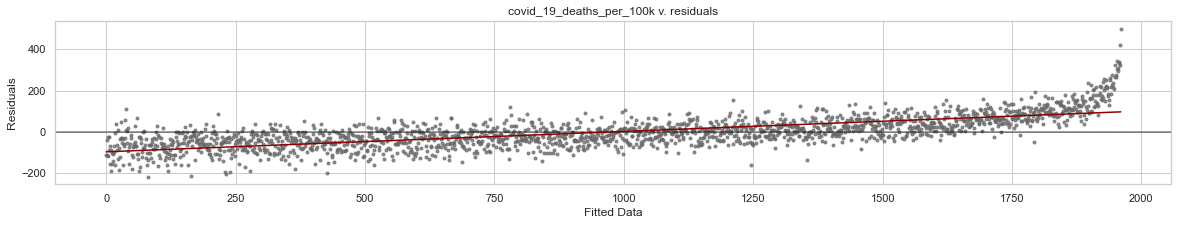

In [ ]:
figure = plt.figure(figsize=(20, 3))
axes = figure.add_subplot(1, 1, 1)
residualsChart(axes,covid.covid_19_deaths_per_100k,result_m5["residuals"],add_trend=True)
plt.show()
plt.close()

Our residuals increase as COVID-19 deaths per capita increases, and the right side looks like we are overestimating at an exponential rate. Let's check residual plots by each feature.

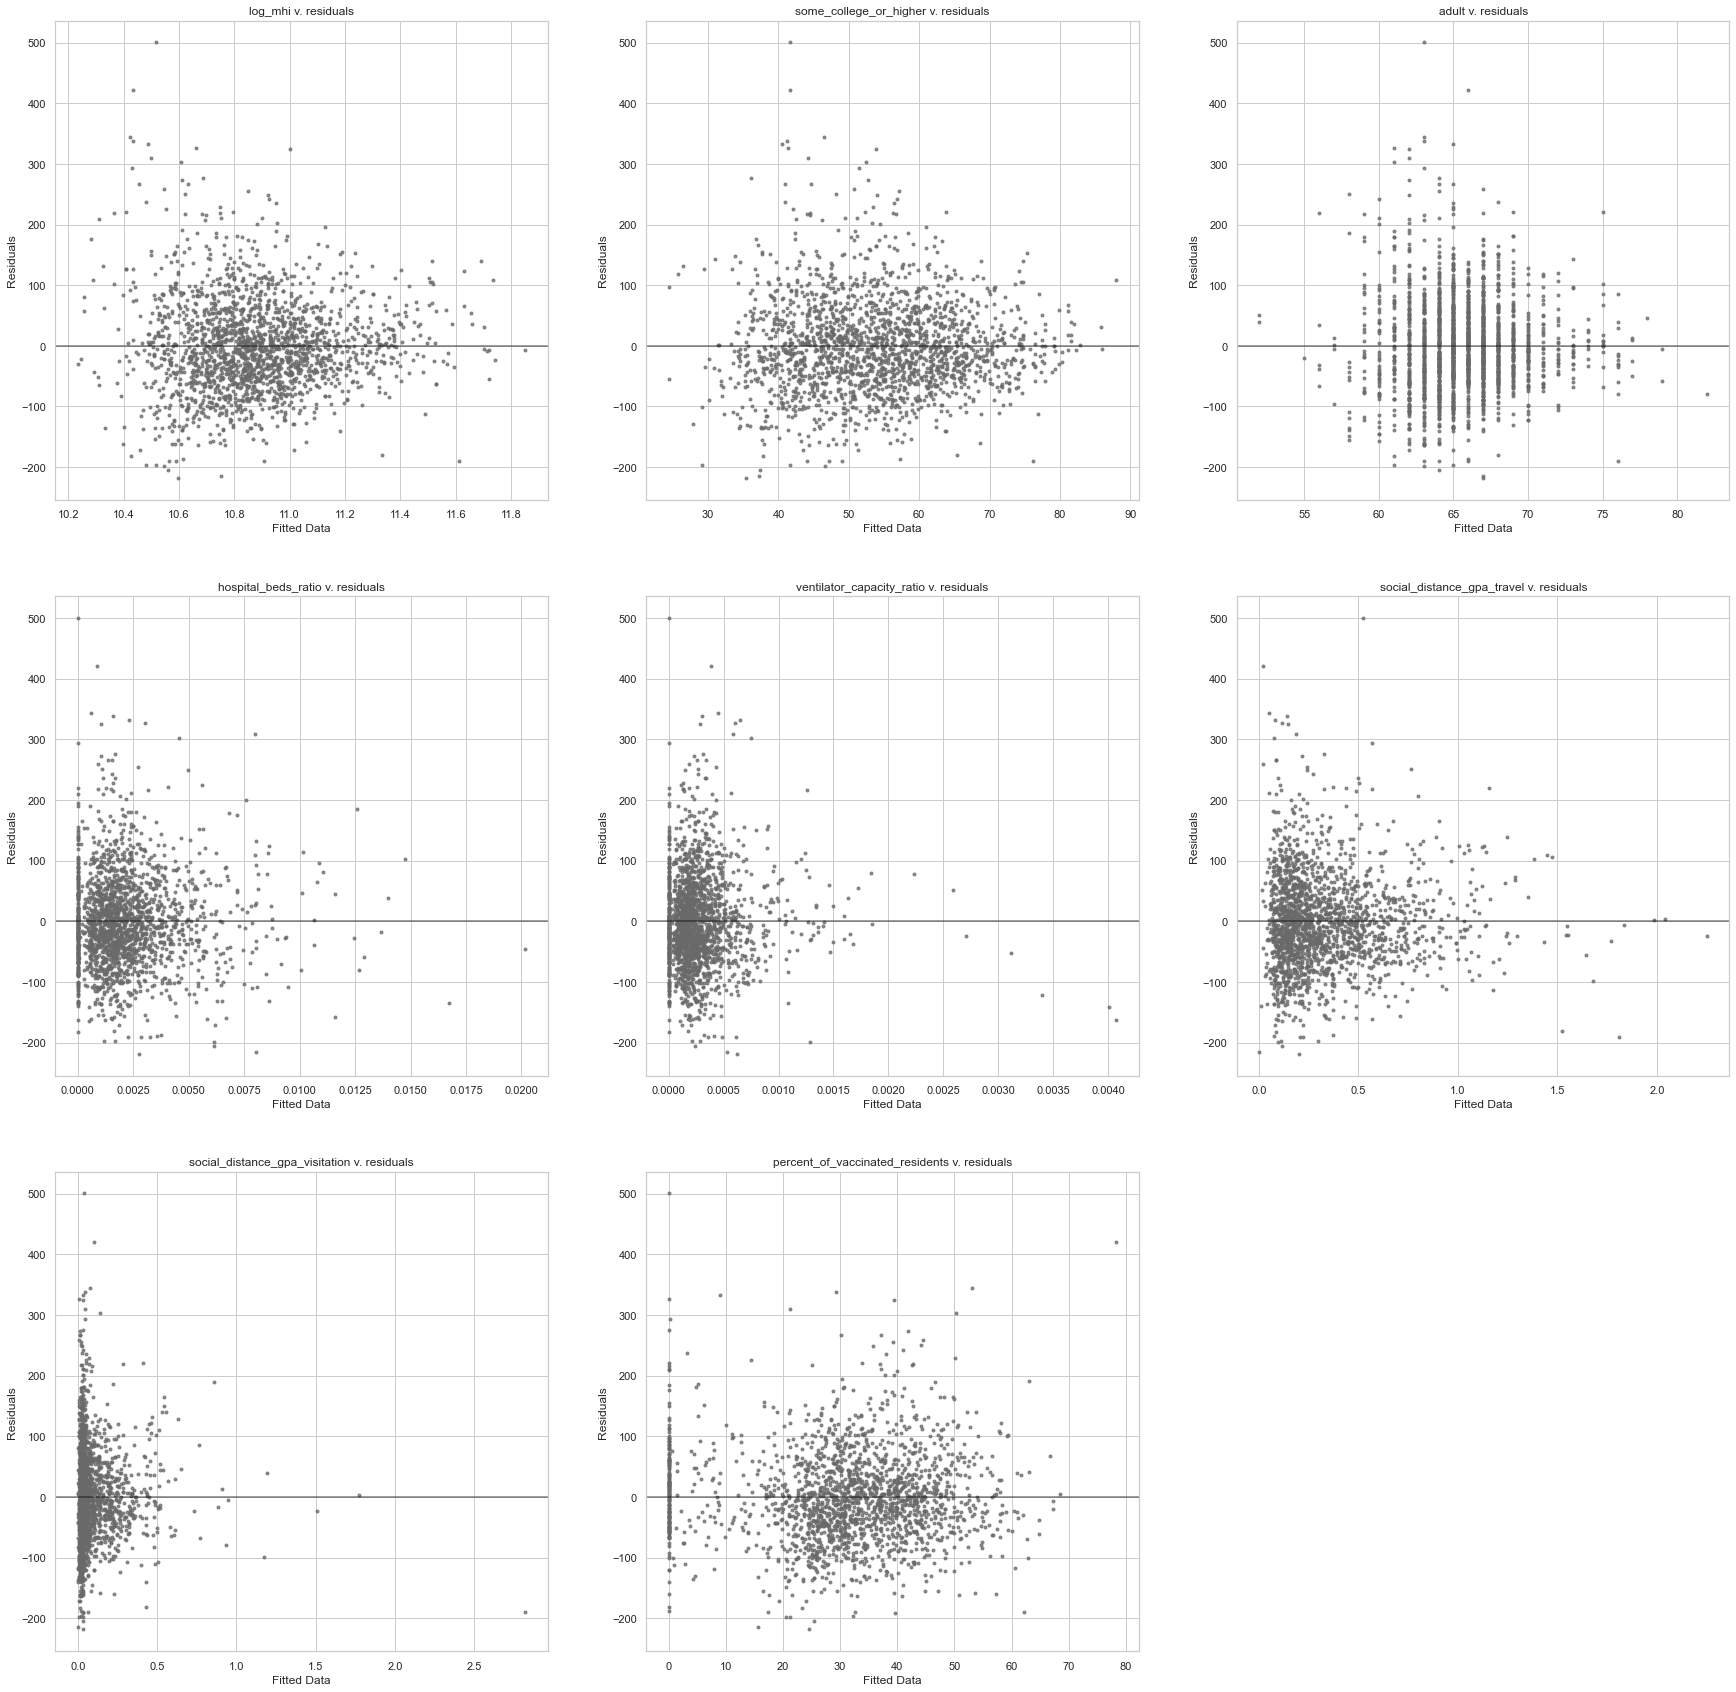

In [ ]:
figure = plt.figure(figsize=(30,30))
variables = list(filter(lambda x: not (":" in x) and not (x in ['intercept']),
                        result_m5["variables"]))
plots = len( variables)
rows = (plots // 3) + 1
for i, variable in enumerate(variables):
    axes = figure.add_subplot(rows, 3, i + 1)
    residualsChart(axes,covid[variable],result_m5["residuals"], sort_x=False)
plt.show()
plt.close()

A few of these variables, like hospital beds ratio, ventilator capacity ratio, and percent of vaccinated residents have many observations at zero. If we turn these into indicator variables, then we can explore more interaction effects with easier interpretations of their coefficients.

In [ ]:
covid["bed_indicator"] = [1 if b > 0 else 0 for b in covid.hospital_beds_ratio]
covid["ventilator_indicator"] = [1 if v > 0 else 0
                                 for v in covid.ventilator_capacity_ratio]
covid["vaccinated_indicator"] = [1 if v > 0 else 0
                                 for v in covid.percent_of_vaccinated_residents]

formula_m6 = 'covid_19_deaths_per_100k ~ log_mhi + some_college_or_higher + \
              adult + bed_indicator + ventilator_indicator + \
              social_distance_gpa_travel + social_distance_gpa_visitation + \
              vaccinated_indicator + \
              log_population_density:high_density + \
              high_density:social_distance_gpa_travel + \
              high_density:ventilator_indicator'
result_m6 = bootstrap_linear_regression(formula_m6, data=covid)
adjusted_r_squared(result_m6)

0.3525933030822821

When we use indicator variables instead of raw values, adjusted R-squared only drops by 0.3%.

In [ ]:
describe_bootstrap_lr(result_m6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,1840.45,1607.20,2126.17
log_mhi,$\beta_{1}$,-100.86,-129.62,-80.50
some_college_or_higher,$\beta_{2}$,-2.70,-3.22,-2.20
adult,$\beta_{3}$,-5.86,-6.94,-4.86
bed_indicator,$\beta_{4}$,-16.23,-53.78,29.22
ventilator_indicator,$\beta_{5}$,42.02,-3.73,84.75
social_distance_gpa_travel,$\beta_{6}$,-79.07,-99.65,-54.39
social_distance_gpa_visitation,$\beta_{7}$,55.74,14.85,114.55
vaccinated_indicator,$\beta_{8}$,-38.84,-53.15,-28.83


The hospital bed indicator is no longer significant, so I will remove it. The ventilator indicator has a significant interaction effect with high density, so I will leave it in. Let's try some more interaction effects to see if we can make up for the loss in predictive power.

I think vaccinated residents might have an interaction with median household income, since the vaccinated resident indicator is a good representation of the population's willingness to prevent COVID-19. Rich counties that are willing to prevent COVID-19 likely spend more of their income on other preventative measures too.

I think the vaccinated residents might also have an interaction with age, since older people are generally more at-risk and on priority for the vaccine. I will add the old variable back into the model to see if it has any effect.

In [ ]:
formula_m7 = 'covid_19_deaths_per_100k ~ log_mhi + some_college_or_higher + \
              adult + old + ventilator_indicator + \
              social_distance_gpa_travel + social_distance_gpa_visitation + \
              vaccinated_indicator + \
              log_population_density:high_density + \
              high_density:social_distance_gpa_travel + \
              high_density:ventilator_indicator + \
              vaccinated_indicator:log_mhi + \
              vaccinated_indicator:adult + \
              vaccinated_indicator:old'
result_m7 = bootstrap_linear_regression(formula_m7, data=covid)
adjusted_r_squared(result_m7)

0.3615839422393775

This is the highest predictive power that we have gotten from any model so far. Let's check coefficients.

In [ ]:
describe_bootstrap_lr(result_m7)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,3656.96,2914.14,4677.82
log_mhi,$\beta_{1}$,-241.57,-326.22,-174.10
some_college_or_higher,$\beta_{2}$,-2.63,-3.23,-2.14
adult,$\beta_{3}$,-9.63,-14.25,-5.49
old,$\beta_{4}$,-3.29,-6.63,-0.11
ventilator_indicator,$\beta_{5}$,26.12,14.55,39.35
social_distance_gpa_travel,$\beta_{6}$,-77.88,-107.69,-55.58
social_distance_gpa_visitation,$\beta_{7}$,53.41,18.16,109.19
vaccinated_indicator,$\beta_{8}$,-1966.27,-2771.87,-1117.56


It looks like the vaccinated residents indicator did not have much of an interaction with either age level, so I will remove these and old from the model. The interaction between vaccinated residents and log median household income is definitely positive. Let's make the final model.

In [ ]:
formula_m8 = 'covid_19_deaths_per_100k ~ log_mhi + some_college_or_higher + \
              adult + ventilator_indicator + social_distance_gpa_travel + \
              social_distance_gpa_visitation + vaccinated_indicator + \
              log_population_density:high_density + \
              high_density:social_distance_gpa_travel + \
              high_density:ventilator_indicator + \
              vaccinated_indicator:log_mhi'
result_m8 = bootstrap_linear_regression(formula_m8, data=covid)
adjusted_r_squared(result_m8)

0.36107444780749876

In [ ]:
describe_bootstrap_lr(result_m8)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,3337.92,2714.90,3995.08
log_mhi,$\beta_{1}$,-239.61,-297.94,-181.21
some_college_or_higher,$\beta_{2}$,-2.69,-3.03,-2.26
adult,$\beta_{3}$,-5.75,-7.16,-4.65
ventilator_indicator,$\beta_{4}$,27.00,18.44,37.83
social_distance_gpa_travel,$\beta_{5}$,-78.31,-102.98,-59.19
social_distance_gpa_visitation,$\beta_{6}$,54.78,15.96,102.33
vaccinated_indicator,$\beta_{7}$,-1662.14,-2351.25,-1061.24
log_population_density:high_density,$\beta_{8}$,11.11,4.46,19.31


This looks like a solid, interpretable model. I am a little concerned about the method of distinguishing high-density and low-density counties, so I want to make validation curves for the population density cutoff.

In [ ]:
density_values = list(range(100, 310, 10))

formulas = []
formula = 'covid_19_deaths_per_100k ~ log_mhi + some_college_or_higher + \
           adult + ventilator_indicator + \
           social_distance_gpa_travel + social_distance_gpa_visitation + \
           vaccinated_indicator + vaccinated_indicator:log_mhi'

data = covid.copy()

for v in density_values:
    label = "density_over_" + str(v)
    data[label] = [1 if d >= v else 0 for d in data.population_density]

    f = formula + f" + {label}:log_population_density \
                     + {label}:social_distance_gpa_travel \
                     + {label}:ventilator_capacity_ratio"
    formulas.append(f)

def f(formula, data, v):
    return linear_regression(formula, data, style="linear")

def r(result):
    return result["sigma"]

density_validation = validation_curves(f, formulas, data, density_values, r)

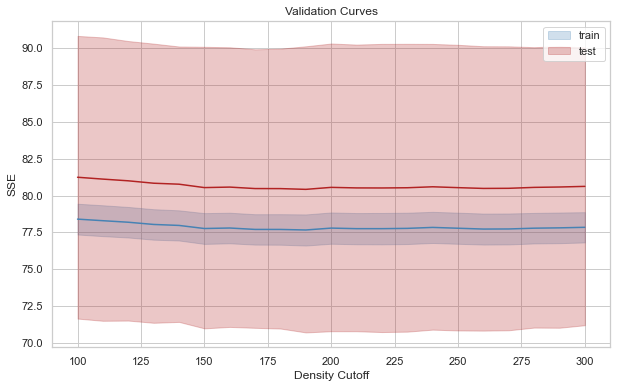

In [ ]:
plot_validation_curves(density_validation, "SSE", "Density Cutoff", density_values)

In [ ]:
test_validation = pd.DataFrame(results_to_curves("test", density_validation)[1:]).T
test_validation.columns = ["lower", "mean", "upper"]
test_validation["cutoff"] = density_values
test_validation.sort_values("mean").head()

,lower,mean,upper,cutoff
9,70.699678,80.420291,90.140903,190
8,70.963125,80.471362,89.979599,180
7,71.012343,80.474357,89.936371,170
16,70.822828,80.483801,90.144774,260
17,70.845735,80.491683,90.137631,270


In [ ]:
covid["density_over_190"] = [1 if d >= 190 else 0 for d in covid.population_density]

formula_m8 = 'covid_19_deaths_per_100k ~ log_mhi + some_college_or_higher + \
              adult + ventilator_indicator + social_distance_gpa_travel + \
              social_distance_gpa_visitation + vaccinated_indicator + \
              density_over_190:log_population_density + \
              density_over_190:social_distance_gpa_travel + \
              density_over_190:ventilator_indicator + \
              vaccinated_indicator:log_mhi'

result_m8 = bootstrap_linear_regression(formula_m8, data=covid)
adjusted_r_squared(result_m8)

0.361629322793254

In [ ]:
describe_bootstrap_lr(result_m8)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,3340.52,2696.61,3956.22
log_mhi,$\beta_{1}$,-239.60,-293.78,-182.81
some_college_or_higher,$\beta_{2}$,-2.69,-3.25,-2.24
adult,$\beta_{3}$,-5.79,-7.32,-4.29
ventilator_indicator,$\beta_{4}$,27.00,17.78,38.36
social_distance_gpa_travel,$\beta_{5}$,-77.91,-101.32,-57.49
social_distance_gpa_visitation,$\beta_{6}$,54.75,14.66,100.00
vaccinated_indicator,$\beta_{7}$,-1665.60,-2359.82,-1004.70
density_over_190:log_population_density,$\beta_{8}$,10.75,3.95,19.03
